> ## ⚠️ Important Lab Disclaimer
> This lab requires API keys (OpenAI, Tavily, OpenWeather) if you want to run the live examples.  
> These keys stay only inside the **temporary Udemy lab workspace** and are **not persisted or shared**, but you should still treat them like any other secret.  
> Use your own discretion when entering keys, and feel free to **revoke or rotate** them after the lab.  
> If you prefer **not** to use real API keys, Copy paste away or download the notebook and run it locally.


This script securely collects three API keys (`OPENAI_API_KEY`, `TAVILY_API_KEY`, `OPENWEATHER_API_KEY`) using `getpass` so your input is hidden.  
It then creates/overwrites a `.env` file and writes each key as `NAME=value` on its own line.  
Finally, it prints **“Saved .env”** when finished.


In [ ]:
from getpass import getpass

names = ["OPENAI_API_KEY", "TAVILY_API_KEY", "OPENWEATHER_API_KEY"]
with open(".env", "w", encoding="utf-8") as f:
    for n in names:
        f.write(f"{n}={getpass(f'Enter {n}: ').strip()}\n")
print("Saved .env")


This code locates the nearest `.env` file in the current working directory (using `find_dotenv`) and loads its key–value pairs into the environment (using `load_dotenv`).  
It does **not** overwrite any existing environment variables because `override=False`.


In [1]:
from dotenv import load_dotenv, find_dotenv
env_path = find_dotenv(usecwd=True)
load_dotenv(env_path, override=False)

True

In [2]:
from __future__ import annotations

# Standard library
import json
import os
import re
from operator import add
from typing import Dict, List
import requests

# Typing helpers
from typing_extensions import Annotated, TypedDict

# Third-party
from IPython.display import Image, display
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END


In [4]:

llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

##### Overview
This workflow takes a user’s NYC trip request, pulls live weather and web context, and uses both to produce a concise, weather-aware, neighborhood-clustered itinerary.

---

##### State
The state stores four things:  
- the user’s prompt  
- Tavily search results  
- a 3-day NYC weather summary  
- the final itinerary generated by the LLM

---

##### `openweather_simple`
Fetches a short, midday-based 3-day NYC forecast using OpenWeather.  
If the API key is missing or the request fails, it returns a clear fallback message.

---

##### `tavily`
Runs a small web search using Tavily and returns up to a few formatted results.  
If nothing is found, it returns a simple “No web results.” message.

---

##### `search_web`
Constructs an NYC-travel query from the user’s prompt and stores the Tavily results in state.

---

##### `fetch_weather`
Gets the 3-day forecast (via `openweather_simple`) and stores it in state.

---

##### `plan_itinerary`
Combines the user’s prompt, the weather summary, and the web context into one system-plus-human prompt.  
The LLM then creates a compact day-by-day itinerary with morning/afternoon/evening blocks, subway hints, food options, and weather-aware adjustments.

---

##### Graph Flow
- Both **web search** and **weather fetch** run immediately from the start.  
- Their results converge into **plan_itinerary**, which produces the final itinerary.  
- The graph is compiled and visually displayed to show this three-step pipeline.


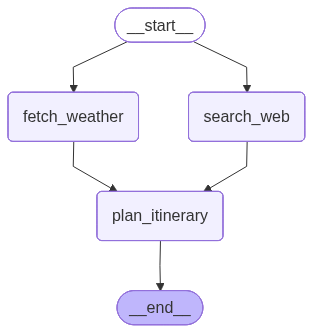

In [5]:

class State(TypedDict, total=False):
    prompt: str      # the ONLY user input
    web: str         # Tavily results (formatted)
    weather: str     # NYC 3-day summary (OpenWeather)
    itinerary: str   # final plan (output)

# ------- Minimal OpenWeather (NYC-only) -------
OPENWEATHER_API_KEY = os.getenv("OPENWEATHER_API_KEY")

def openweather_simple(days: int = 3) -> str:
    """Tiny 3-line-per-day summary via a single forecast call (NYC only)."""
    if not OPENWEATHER_API_KEY:
        return "Weather unavailable: OPENWEATHER_API_KEY not set in .env"
    lat, lon = 40.7128, -74.0060  # NYC coords
    try:
        r = requests.get(
            "https://api.openweathermap.org/data/2.5/forecast",
            params={"lat": lat, "lon": lon, "appid": OPENWEATHER_API_KEY, "units": "metric"},
            timeout=15,
        )
        r.raise_for_status()
        data = r.json().get("list", [])
        # Pick the first ~midday entry per date for N days
        lines, seen = [], set()
        for e in data:
            dt_txt = e.get("dt_txt", "")
            if " 12:00:00" not in dt_txt:
                continue
            day = dt_txt.split(" ")[0]
            if day in seen:
                continue
            weather = (e.get("weather") or [{}])[0]
            desc = weather.get("description", "—")
            temp = round(e.get("main", {}).get("temp", 0))
            feels = round(e.get("main", {}).get("feels_like", temp))
            lines.append(f"{day}: {desc}; ~{temp}°C (feels {feels}°C)")
            seen.add(day)
            if len(lines) == days:
                break
        return "NYC 3-Day Weather (OpenWeather):\n" + ("\n".join(lines) if lines else "No forecast available.")
    except requests.RequestException as e:
        return f"Weather unavailable: {e}"

def tavily(query: str, max_results: int = 3) -> str:
    tool = TavilySearchResults(max_results=max_results)
    results = tool.invoke(query) or []
    if not results:
        return "No web results."
    return "\n\n---\n\n".join(
        f'<Document href="{r.get("url","")}">\n{r.get("content","")}\n</Document>'
        for r in results if "url" in r and "content" in r
    )

def search_web(state: State) -> State:
    web = tavily(
        f"NYC travel planning: {state['prompt']} "
        "(top sights, food, neighborhoods, family tips, rain/cold options)"
    )
    return {"web": web}

def fetch_weather(state: State) -> State:
    return {"weather": openweather_simple(days=3)}

def plan_itinerary(state: State) -> State:
    sys = SystemMessage(content=(
        "You are an efficient NYC trip planner. Create a realistic, walkable, day-by-day itinerary. "
        "Cluster by neighborhood to minimize transit; for each block include a quick why-it-matters and nearest subway. "
        "If weather suggests rain/cold, bias indoor choices. Include food near each block. Keep each day ~10am–8pm."
        "\n\n--- WEATHER ---\n" + state.get("weather","") +
        "\n\n--- WEB_CONTEXT ---\n" + state.get("web","")
    ))
    human = HumanMessage(content=(
        "Using the WEATHER and WEB_CONTEXT above, generate a concise itinerary.\n"
        "Output format:\n"
        "Day N\n"
        "- Morning: … (why, nearest subway)\n"
        "- Afternoon: … (why, nearest subway)\n"
        "- Evening: … (why, nearest subway)\n"
        "Finish each day with one tip (budget/time/weather).\n\n"
        "User prompt:\n" + state["prompt"]
    ))
    print(sys)
    resp = llm.invoke([sys, human])
    itinerary = getattr(resp, "content", str(resp))
    return {"itinerary": itinerary}

g = StateGraph(State)
g.add_node("search_web", search_web)
g.add_node("fetch_weather", fetch_weather)
g.add_node("plan_itinerary", plan_itinerary)

g.add_edge(START, "search_web")
g.add_edge(START, "fetch_weather")
g.add_edge("search_web", "plan_itinerary")
g.add_edge("fetch_weather", "plan_itinerary")
g.add_edge("plan_itinerary", END)

graph = g.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [6]:
test_prompt = "3-day NYC with kids; love pizza and parks; one Broadway show."

This snippet prints a labeled 3-day NYC weather summary.

1. It prints a header line: `=== WEATHER ===`.
2. It calls `openweather_simple(days=3)` to get a short, 3-day NYC forecast string.
3. It prints that forecast right below the header.


In [7]:
print("\n=== WEATHER ===")
print(openweather_simple(days=3))


=== WEATHER ===
NYC 3-Day Weather (OpenWeather):
2025-12-03: clear sky; ~0°C (feels -5°C)
2025-12-04: scattered clouds; ~1°C (feels -3°C)
2025-12-05: clear sky; ~-3°C (feels -3°C)


This prints the Tavily web context for a given query.

1. It prints a header: `=== TAVILY WEB CONTEXT ===`.
2. It runs `tavily(test_prompt, max_results=5)` to fetch up to 5 formatted search results.
3. It prints those results underneath the header.


In [8]:
print("\n=== TAVILY WEB CONTEXT ===")
print(tavily(test_prompt, max_results=5))


=== TAVILY WEB CONTEXT ===


C:\Users\ryanb\AppData\Local\Temp\ipykernel_49528\77709596.py:45: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=max_results)


<Document href="https://sachaeats.com/nyc-itinerary-3-days/">
Like many, one of my favorite cities in the world is New York City. From trips as a kid for my favorite Broadway shows to food and shopping excursions, I’ve visited the city dozens of times and know it quite well now. This is the ultimate NYC itinerary 3 days travel guide highlighting the best attractions, foods, and things to do. I also include general travel tips for New York including how to get around and where to stay. [...] Stroll through the tree-lined streets of the West Village neighborhood. It’s one of my favorite areas in all of New York City. In addition to its restaurants, boutiques, and bars, it is home to the Friends Apartment building.

Whatever you decide to eat on your NYC itinerary 3 days, you MUST try L’industrie Pizzeria on Christopher Street. It’s my favorite pizza shop in all of New York City, famous for its burrata-topped slices!

### Washington Square Park [...] My go-to activity in NYC is a musical 

This generates and prints a complete NYC itinerary.

1. A detailed trip prompt is provided to the graph.  
2. The graph gathers web context, fetches weather, and produces the itinerary.  
3. A header `=== NYC Itinerary ===` is printed.  
4. The final itinerary text is printed below it.


In [10]:
prompt = "3-day NYC trip with kids; love pizza, Central Park, and one Broadway show; minimize long subway rides."
result = graph.invoke({"prompt": prompt})
print("\n=== NYC Itinerary ===\n")
print(result["itinerary"])

content='You are an efficient NYC trip planner. Create a realistic, walkable, day-by-day itinerary. Cluster by neighborhood to minimize transit; for each block include a quick why-it-matters and nearest subway. If weather suggests rain/cold, bias indoor choices. Include food near each block. Keep each day ~10am–8pm.\n\n--- WEATHER ---\nNYC 3-Day Weather (OpenWeather):\n2025-12-03: clear sky; ~0°C (feels -5°C)\n2025-12-04: scattered clouds; ~1°C (feels -3°C)\n2025-12-05: clear sky; ~-3°C (feels -3°C)\n\n--- WEB_CONTEXT ---\n<Document href="https://practicalwanderlust.com/new-york-city-itinerary/">\nThis itinerary can be used for 3, 4, or 5 days, depending on your preference and the days can really be used in any order, depending on the weather / when things are open. For example, strolling through Central Park on a rainy day may not be your cup of tea (but still magical in its own way!), Broadway shows don’t play on Mondays, and the MET is closed Wednesdays.\n</Document>\n\n---\n\n<Docu

**Overall State**  
`NYCState` holds everything needed for a staged NYC itinerary workflow:  
- the raw user `prompt`  
- parsed preference flags (`prefs`)  
- parsed trip length (`days`)  
- weather and web summaries from subgraphs  
- the final `itinerary`  
- `notes` used as lightweight breadcrumbs throughout the pipeline

**Preference + Days Extraction (`parse_prefs`)**  
This function inspects the user prompt and:  
- Detects interests (museums, food), weather concerns (indoor-friendly), mobility style (walkable), and assumes subway access.  
- Extracts trip length by looking for patterns like “2 days,” clamping between 1–5.  
- Returns the parsed prefs, the computed days, and breadcrumb notes summarizing both.

In [11]:
# =========================
# Minimal overall state
# =========================
class NYCState(TypedDict):
    prompt: str                                  # user prompt
    prefs: Dict[str, bool]                       # parsed prefs
    days: int                                    # trip horizon (parsed)
    weather_summary: str                         # from Weather subgraph
    query: str                                   # from Tavily subgraph
    web_summary: str                             # from Tavily subgraph
    itinerary: str                               # final output
    notes: Annotated[List[str], add]             # breadcrumbs

DAYS_PAT = re.compile(r"\b(\d{1,2})\s*(day|days)\b", re.I)

def parse_prefs(state: NYCState):
    p = state["prompt"].lower()
    prefs = {
        "museums": bool(re.search(r"\bmuseum|art|gallery\b", p)),
        "food": bool(re.search(r"\bfood|eat|restaurant|pizza|bagel|deli|ramen|dumpling\b", p)),
        "indoor_bias": bool(re.search(r"\brain|cold|snow|indoor|weather\b", p)),
        "walkable": bool(re.search(r"\bwalk|walkable|on foot\b", p)),
        "subway_nearby": True,
    }
    days = 2
    if m := DAYS_PAT.search(p):
        days = max(1, min(5, int(m.group(1))))
    return {"prefs": prefs, "days": days, "notes": [f"prefs:{json.dumps(prefs)}", f"days:{days}"]}

##### Weather Subgraph 

**State Shapes**  
- `WeatherState` carries the requested `days`, a `weather_summary` placeholder, and accumulating `notes`.  
- `WeatherOut` is the trimmed output view: the staged `weather_summary` plus `notes`.

**`wx_fetch` (Staged Weather Generator)**  
Takes the requested days (clamped between 1–5) and builds a fully hardcoded forecast:  
- One short line per day (mixed clouds, mild temps, light breeze).  
- A generic tip about packing layers and an umbrella.  
It returns a single joined `weather_summary` string and a note marking that this is staged weather for N days.

**Weather Graph Wiring**  
A tiny LangGraph subgraph:  
- `START → wx_fetch → END`  
- Compiled into `weather_graph` and visualized, providing a deterministic weather module you can plug into the larger NYC itinerary workflow.


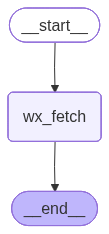

In [12]:
class WeatherState(TypedDict):
    days: int
    weather_summary: str
    notes: Annotated[List[str], add]

class WeatherOut(TypedDict):
    weather_summary: str
    notes: Annotated[List[str], add]

def wx_fetch(state: WeatherState):
    # STAGED deterministic summary (no external calls)
    days = max(1, min(5, state["days"]))
    lines = []
    for i in range(days):
        lines.append(f"Day {i+1}: [STAGED] Mixed clouds, ~10–18°C, light breeze")
    tip = "Tip: [STAGED] Pack layers and a compact umbrella."
    return {"weather_summary": " | ".join(lines) + " | " + tip,
            "notes": [f"weather:staged:{days}d"]}    

wx_builder = StateGraph(state_schema=WeatherState, output_schema=WeatherOut)
wx_builder.add_node("wx_fetch", wx_fetch)
wx_builder.add_edge(START, "wx_fetch")
wx_builder.add_edge("wx_fetch", END)
weather_graph = wx_builder.compile()
display(Image(weather_graph.get_graph().draw_mermaid_png()))

##### Tavily Subgraph 

**State Shapes**  
- `TavilyState` holds the original `prompt`, a derived search `query`, a staged `web_summary`, and accumulating `notes`.  
- `TavilyOut` exposes just the final `web_summary`, `query`, and `notes` back to the parent graph.

**`craft_query` (Search Query Builder)**  
Reads the user prompt and builds a NYC travel search query that always includes walkable neighborhoods and food near subways.  
It conditionally adds extra phrases for museums, food, or indoor/weather concerns, then records the full query as a breadcrumb note.

**`call_tavily` (Staged Web Summary)**  
Instead of calling the real API, returns a fixed set of bullet points about clustered NYC neighborhoods (museums, parks, food loops) plus a note marking it as staged Tavily output.

**Tavily Graph Wiring**  
A small two-step subgraph:  
- `START → craft_query → call_tavily → END`  
Compiled into `tavily_graph` and visualized, it serves as a deterministic “web context” module for the larger NYC itinerary workflow.


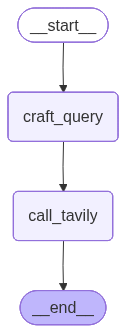

In [13]:
class TavilyState(TypedDict):
    prompt: str
    query: str
    web_summary: str
    notes: Annotated[List[str], add]

class TavilyOut(TypedDict):
    web_summary: str
    query: str
    notes: Annotated[List[str], add]

def craft_query(state: TavilyState):
    p = state["prompt"].lower()
    base = "NYC trip planner walkable neighborhoods things to do food near subway"
    extras = []
    if re.search(r"\bmuseum|art|gallery\b", p): extras.append("top museums quick visit")
    if re.search(r"\bfood|eat|restaurant|pizza|bagel|deli|ramen|dumpling\b", p): extras.append("great local food")
    if re.search(r"\brain|cold|snow|indoor|weather\b", p): extras.append("indoor activities")
    query = base + (" " + " ".join(extras) if extras else "")
    return {"query": query, "notes": [f"tavily_query:{query}"]}

def call_tavily(state: TavilyState):
    # STAGED deterministic bullets (no external calls)
    summary = "\n".join([
        "Answer: [STAGED] Focus on clustered neighborhoods to minimize transit.",
        "- MoMA & Bryant Park (walkable, Midtown)",
        "- The Met & nearby Museum Mile stops",
        "- Chelsea Market & High Line loop",
    ])
    return {"web_summary": summary, "notes": ["tavily:staged"]}    

tv_builder = StateGraph(state_schema=TavilyState, output_schema=TavilyOut)
tv_builder.add_node("craft_query", craft_query)
tv_builder.add_node("call_tavily", call_tavily)
tv_builder.add_edge(START, "craft_query")
tv_builder.add_edge("craft_query", "call_tavily")
tv_builder.add_edge("call_tavily", END)
tavily_graph = tv_builder.compile()
display(Image(tavily_graph.get_graph().draw_mermaid_png()))


This staged graph turns parsed prefs + staged weather/web context into a simple, neighborhood-clustered NYC itinerary.

---

##### Neighborhood + Food Templates
A small catalog defines:
- **NEIGHBORHOODS**: name, 3 key sights, an indoor score, and a nearby subway stop.
- **EATS**: 1–2 nearby food options per neighborhood.

These act as hardcoded “lego blocks” for the itinerary.

---

##### `_pick_days(days, indoor_bias)`
Chooses up to 3 neighborhoods for the trip:
- If `indoor_bias` is true, it sorts by the indoor score so more indoor-friendly areas come first.
- Returns as many neighborhoods as the clamped day count (1–3).

---

##### `_mk_block(nh, sights, subway)`
Builds a single day’s schedule for one neighborhood:
- Morning / Afternoon / Evening slots, each tied to one sight and the same subway stop.
- Adds nearby food suggestions and a simple transit/ticket tip.
- Returns a formatted text block for that day.

---

##### `build_itinerary(state)`
Uses the staged context and templates to assemble the final plan:
1. Reads `days` and `indoor_bias` from the parsed prefs.
2. Picks the neighborhoods to cover using `_pick_days`.
3. Prepends sections for:
   - **Weather**: from `state["weather_summary"]`
   - **Web Context (Tavily)**: from `state["web_summary"]`
4. For each selected neighborhood/day:
   - Adds `Day N: <Neighborhood>` and the block from `_mk_block`.
5. Returns:
   - `itinerary`: a joined markdown-style string
   - `notes`: a breadcrumb summarizing days and indoor bias

---

##### Main NYC Graph Wiring
The overall `nyc_graph` wires everything together:

- **Nodes**
  - `parse_prefs`: derive `prefs`, `days`, and notes from the raw prompt.
  - `weather`: run the staged `weather_graph` subgraph.
  - `tavily`: run the staged `tavily_graph` subgraph.
  - `build_itinerary`: combine prefs + weather + web summary into the final itinerary.

- **Flow**
  - `START → parse_prefs`
  - From `parse_prefs`, fan out to **both** `weather` and `tavily`.
  - When both subgraphs finish, their outputs feed into `build_itinerary`.
  - `build_itinerary → END` returns the final staged NYC itinerary.

The `xray=1` Mermaid visualization shows this as a main graph with two nested subgraphs feeding a single itinerary builder.


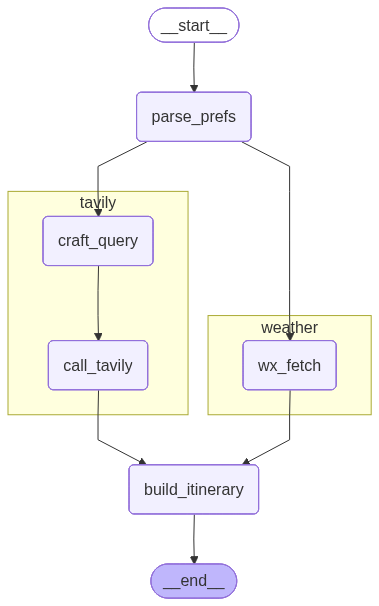

In [14]:
NEIGHBORHOODS = [
    ("Midtown", ["MoMA", "Bryant Park", "Times Sq"], 0.6, "47–50 St / 42 St"),
    ("Museum Mile", ["The Met", "Guggenheim", "Central Park edge"], 0.9, "86 St / 77 St"),
    ("Chelsea & Meatpacking", ["High Line", "Chelsea Market", "Whitney"], 0.5, "14 St"),
]
EATS = {
    "Midtown": ["Halal Guys", "Los Tacos No. 1"],
    "Museum Mile": ["Uva (Italian)", "Madison Ave cafés"],
    "Chelsea & Meatpacking": ["Chelsea Market stalls", "Buddakan"],
}

def _pick_days(days: int, indoor_bias: bool):
    ranked = sorted(NEIGHBORHOODS, key=lambda x: x[2], reverse=indoor_bias)
    return ranked[:max(1, min(3, days))]

def _mk_block(nh: str, sights: List[str], subway: str):
    morning = f"{sights[0]} — why: signature; subway: {subway}"
    afternoon = f"{sights[1]} — why: nearby & walkable; subway: {subway}"
    evening = f"{sights[2]} — why: good finish; subway: {subway}"
    eats = ", ".join(EATS.get(nh, [])[:2])
    tip = "Tip: buy timed tickets for popular spots; use OMNY/MetroCard."
    return f"- Morning: {morning}\n- Afternoon: {afternoon}\n- Evening: {evening}\nNearby eats: {eats}\n{tip}"

def build_itinerary(state: NYCState):
    days = state["days"]
    indoor_bias = bool(state["prefs"].get("indoor_bias"))
    picks = _pick_days(days, indoor_bias)

    lines = []
    lines.append("### Weather\n" + (state["weather_summary"] or "[no weather]"))
    lines.append("\n### Web Context (Tavily)\n" + (state["web_summary"] or "[no web]"))

    for i, (nh, sights, _, subway) in enumerate(picks, start=1):
        lines.append(f"\nDay {i}: {nh}")
        lines.append(_mk_block(nh, sights, subway))

    return {"itinerary": "\n".join(lines), "notes": [f"itinerary:days={days},indoor_bias={indoor_bias}"]}


g = StateGraph(NYCState)
g.add_node("parse_prefs", parse_prefs)
g.add_node("weather", weather_graph)   # nested subgraph (1 staged node)
g.add_node("tavily", tavily_graph)     # nested subgraph (2 staged nodes)
g.add_node("build_itinerary", build_itinerary)

g.add_edge(START, "parse_prefs")
g.add_edge("parse_prefs", "weather")
g.add_edge("parse_prefs", "tavily")
g.add_edge("weather", "build_itinerary")
g.add_edge("tavily", "build_itinerary")
g.add_edge("build_itinerary", END)

nyc_graph = g.compile()
display(Image(nyc_graph.get_graph(xray=1).draw_mermaid_png()))

In [15]:
user_prompt = (
    "Plan a 2-day NYC trip, mostly walkable. If it looks rainy or cold, lean indoors. "
    "We love museums and good food near subway stops."
)

result = nyc_graph.invoke({
    "prompt": user_prompt,
    "prefs": {},
    "days": 0,
    "weather_summary": "",
    "query": "",
    "web_summary": "",
    "itinerary": "",
    "notes": [],
})

print("======== ITINERARY ========")
print(result["itinerary"])
print("\n======== NOTES ========")
print(result["notes"])

======== ITINERARY ========
### Weather
Day 1: [STAGED] Mixed clouds, ~10–18°C, light breeze | Day 2: [STAGED] Mixed clouds, ~10–18°C, light breeze | Tip: [STAGED] Pack layers and a compact umbrella.

### Web Context (Tavily)
Answer: [STAGED] Focus on clustered neighborhoods to minimize transit.
- MoMA & Bryant Park (walkable, Midtown)
- The Met & nearby Museum Mile stops
- Chelsea Market & High Line loop

Day 1: Museum Mile
- Morning: The Met — why: signature; subway: 86 St / 77 St
- Afternoon: Guggenheim — why: nearby & walkable; subway: 86 St / 77 St
- Evening: Central Park edge — why: good finish; subway: 86 St / 77 St
Nearby eats: Uva (Italian), Madison Ave cafés
Tip: buy timed tickets for popular spots; use OMNY/MetroCard.

Day 2: Midtown
- Morning: MoMA — why: signature; subway: 47–50 St / 42 St
- Afternoon: Bryant Park — why: nearby & walkable; subway: 47–50 St / 42 St
- Evening: Times Sq — why: good finish; subway: 47–50 St / 42 St
Nearby eats: Halal Guys, Los Tacos No. 1
Tip:

##### LLM-Driven Prefs Parser 
This version uses a real LLM (with structured output) to parse trip preferences and days from a free-text NYC prompt.

---

##### App State (`NYCState`)
Holds everything the overall app needs:
- `prompt`: raw user text  
- `prefs`: parsed boolean preferences  
- `days`: parsed trip length (1–5)  
- `weather_summary`, `query`, `web_summary`: context from other nodes  
- `itinerary`: final plan  
- `notes`: running breadcrumbs

---

##### Structured Schemas (`Prefs`, `ParsedPrefs`)
- `Prefs`: normalized preference flags (`museums`, `food`, `indoor_bias`, `walkable`, `subway_nearby`).
- `ParsedPrefs`: wraps `prefs` plus `days`, with `days` defaulting to 2 if not specified.

These schemas tell the LLM exactly what JSON-shaped output we expect.

---

##### LLM Setup
- `llm_struct = llm.with_structured_output(ParsedPrefs)` forces the LLM to return data conforming to `ParsedPrefs`.

---

##### `parse_prefs_llm(state)`
This function turns the user’s prompt into clean, bounded prefs + days:

1. Sends a system message that explains the schema and rules (including that `subway_nearby` must be true and `days` defaults to 2).
2. Sends the user prompt as the content to parse.
3. Invokes the structured LLM and normalizes the result (`model_dump` / `dict` / raw).
4. Merges with `DEFAULT_PREFS` to ensure all preference keys are present.
5. Forces `subway_nearby = True` regardless of LLM output.
6. Clamps `days` between 1 and 5.
7. Returns:
   - `prefs`: a complete, normalized preference dict  
   - `days`: the sanitized day count  
   - `notes`: JSON-encoded prefs and days for easy debugging or tracing


In [16]:
# --- App state ---
class NYCState(TypedDict):
    prompt: str
    prefs: Dict[str, bool]
    days: int
    weather_summary: str
    query: str
    web_summary: str
    itinerary: str
    notes: Annotated[List[str], add]

# --- Structured output schema ---
class Prefs(BaseModel):
    museums: bool = False
    food: bool = False
    indoor_bias: bool = False
    walkable: bool = False
    subway_nearby: bool = True  # always true

class ParsedPrefs(BaseModel):
    prefs: Prefs
    days: int = Field(2, description="Trip days; default 2 if unspecified")

llm_struct = llm.with_structured_output(ParsedPrefs)

# --- Parser function ---
DEFAULT_PREFS = {
    "museums": False,
    "food": False,
    "indoor_bias": False,
    "walkable": False,
    "subway_nearby": True,
}

def parse_prefs_llm(state: NYCState):
    messages = [
        {"role": "system",
         "content": ("Extract trip preferences and days. Return JSON matching the schema. "
                     "prefs keys: museums, food, indoor_bias, walkable, subway_nearby (must be true). "
                     "days default 2 if missing.")},
        {"role": "user", "content": state["prompt"]},
    ]
    result = llm_struct.invoke(messages)

    # Normalize
    if hasattr(result, "model_dump"):   # pydantic v2
        data = result.model_dump()
    elif hasattr(result, "dict"):       # pydantic v1
        data = result.dict()
    else:
        data = result

    # Merge with defaults so all keys exist
    prefs_raw = data.get("prefs") or {}
    if hasattr(prefs_raw, "model_dump"):
        prefs_raw = prefs_raw.model_dump()
    elif hasattr(prefs_raw, "dict"):
        prefs_raw = prefs_raw.dict()

    prefs = {**DEFAULT_PREFS, **(prefs_raw or {})}
    prefs["subway_nearby"] = True  # enforce

    days = max(1, min(5, data.get("days", 2)))


    return {
        "prefs": prefs,
        "days": days,
        "notes": [
            f"prefs:{json.dumps(prefs)}",
            f"days:{days}"
        ]
    }


c:\Users\ryanb\coding_projects\easy_langgraph\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1949: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo-0125 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


This snippet shows the LLM prefs parser in action.

- `parse_prefs_llm(state)` is called to turn that prompt into structured data: normalized `prefs` plus a clamped `days` value.
- The returned dict (including prefs, days, and notes) is printed as pretty JSON so you can inspect what the LLM extracted.


In [17]:

state = {
    "prompt": "Plan a 3-day trip focusing on museums and food, mostly indoor activities."
}

result = parse_prefs_llm(state)

print(json.dumps(result, indent=2))


{
  "prefs": {
    "museums": true,
    "food": true,
    "indoor_bias": true,
    "walkable": false,
    "subway_nearby": true
  },
  "days": 3,
  "notes": [
    "prefs:{\"museums\": true, \"food\": true, \"indoor_bias\": true, \"walkable\": false, \"subway_nearby\": true}",
    "days:3"
  ]
}


This subgraph turns a requested day count into a **live OpenWeather summary** plus trace notes.

- **State shapes**
  - `WeatherState`: carries the input `days`, a `weather_summary` slot, and accumulating `notes`.
  - `WeatherOut`: output view exposing just `weather_summary` and `notes` back to the main graph.

- **`wx_fetch`**
  - Clamps `days` to the range 1–5.
  - Calls `openweather_simple(days)` to get a real forecast string.
  - On any error, returns a clear “Weather unavailable (…)” message instead.
  - Adds a breadcrumb note like `weather:live_openweather:3d`.

- **Weather graph**
  - A single-node LangGraph: `START → wx_fetch → END`.
  - Compiled into `weather_graph` and visualized; this becomes the live weather module used by the main NYC planner.


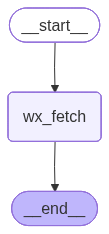

In [18]:
class WeatherState(TypedDict):
    days: int
    weather_summary: str
    notes: Annotated[List[str], add]

class WeatherOut(TypedDict):
    weather_summary: str
    notes: Annotated[List[str], add]

def wx_fetch(state: WeatherState):
    # Clamp number of days between 1 and 5
    days = max(1, min(5, state["days"]))

    # Call the real OpenWeather API via your provided helper
    try:
        summary = openweather_simple(days)
    except Exception as e:
        summary = f"Weather unavailable ({e})."

    return {
        "weather_summary": summary,
        "notes": [f"weather:live_openweather:{days}d"]
    }


wx_builder = StateGraph(state_schema=WeatherState, output_schema=WeatherOut)
wx_builder.add_node("wx_fetch", wx_fetch)
wx_builder.add_edge(START, "wx_fetch")
wx_builder.add_edge("wx_fetch", END)
weather_graph = wx_builder.compile()
display(Image(weather_graph.get_graph().draw_mermaid_png()))


This snippet runs the live weather subgraph for a 3-day forecast.

- It initializes `inputs` with `days=3` and empty `weather_summary`/`notes`.
- `weather_graph.invoke(inputs)` executes the `wx_fetch` node, which calls OpenWeather (via `openweather_simple`) and fills in the summary.
- Accessing `result["weather_summary"]` returns the final 3-day weather text for use in the main NYC planner.


In [19]:

inputs = {
    "days": 3,                
    "weather_summary": "",    
    "notes": []               
}

result = weather_graph.invoke(inputs)
result["weather_summary"]

'NYC 3-Day Weather (OpenWeather):\n2025-12-03: clear sky; ~0°C (feels -5°C)\n2025-12-04: scattered clouds; ~1°C (feels -3°C)\n2025-12-05: clear sky; ~-3°C (feels -3°C)'

##### Live Tavily Subgraph — Succinct Explanation

This subgraph turns a user’s NYC travel prompt into a **live Tavily web summary** using an LLM-crafted query.

---

State Types
- **TavilyState**: holds the original `prompt`, the derived search `query`, a `web_summary`, and accumulating `notes`.
- **TavilyOut**: exposes `web_summary`, `query`, and `notes` back to the main graph.

---

Structured Query Schema
- **QuerySchema**: a single field `query: str` that must be a concise NYC trip-planning search query.
- `llm_struct = llm.with_structured_output(QuerySchema)` forces the LLM to return exactly that shape.

---

`craft_query_llm`
- Sends system + user messages to the structured LLM to turn the travel prompt into one focused web search query.
- Safely extracts the `query` from the model output.
- Strips whitespace and returns:
  - `query`
  - a breadcrumb note like `tavily_query:<query>`.

---

`call_tavily_live`
- Reads `query` from state; falls back to a generic NYC trip query if it’s empty.
- Calls `TavilySearchResults(max_results=5)` and normalizes the response:
  - Handles list, dict, or string output shapes.
  - If no items, returns a `"No results found from Tavily."` message.
  - Otherwise formats each result as:
    - title (or URL) + truncated content/snippet (up to ~600 chars).
- Returns:
  - `web_summary`: multi-line bullet summary
  - `notes`: e.g. `tavily:live:5 results`.

---

Tavily Graph Wiring
- Nodes:
  - `craft_query` → `craft_query_llm`
  - `call_tavily` → `call_tavily_live`
- Flow:
  - `START → craft_query → call_tavily → END`
- Compiled into `tavily_graph` and visualized; this is the live web-context module for the real NYC planner graph.


c:\Users\ryanb\coding_projects\easy_langgraph\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1949: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo-0125 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


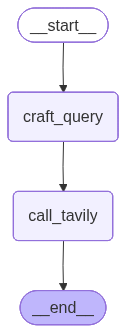

In [20]:

# ----- State types -----
class TavilyState(TypedDict):
    prompt: str
    query: str
    web_summary: str
    notes: Annotated[List[str], add]

class TavilyOut(TypedDict):
    web_summary: str
    query: str
    notes: Annotated[List[str], add]

# ----- Structured schema for query -----
class QuerySchema(BaseModel):
    query: str = Field(..., description="A concise NYC trip planning search query")


llm_struct = llm.with_structured_output(QuerySchema)

# ----- Node: craft query with structured output -----
def craft_query_llm(state: TavilyState):
    messages = [
        {
            "role": "system",
            "content": (
                "You turn a user's travel prompt into a single focused web search query.\n"
                "Context: NYC, walkable trip planning, food, museums, weather considerations.\n"
                "Return ONLY a JSON object matching the schema with a single 'query' string."
            ),
        },
        {
            "role": "user",
            "content": state["prompt"],
        },
    ]

    result = llm_struct.invoke(messages)  # returns pydantic model or dict
    query = (
        result.model_dump().get("query")
        if hasattr(result, "model_dump")
        else (result.get("query") if isinstance(result, dict) else "")
    )
    query = (query or "").strip()

    return {"query": query, "notes": [f"tavily_query:{query}"]}

# ----- Node: call Tavily live -----
# replace call_tavily_live with this more defensive version
def call_tavily_live(state: TavilyState):
    query = (state.get("query") or "").strip()
    if not query:
        # fallback if LLM returned an empty query
        query = "NYC walkable trip plan food museums weather"

    tool = TavilySearchResults(max_results=5)

    # Prefer dict input for compatibility
    raw = tool.invoke({"query": query})

    # Normalize shape: can be list, dict, or str depending on versions/config
    if isinstance(raw, list):
        items = raw
    elif isinstance(raw, dict):
        items = raw.get("results") or raw.get("data") or []
    elif isinstance(raw, str):
        summary = raw.strip() or "No results found from Tavily."
        return {"web_summary": summary, "notes": [f"tavily:live:0 results (string)"] }
    else:
        items = []

    if not items:
        summary = "No results found from Tavily."
        count = 0
    else:
        lines = []
        for res in items:
            if not isinstance(res, dict):
                lines.append(f"- {str(res).strip()[:300]}")
                continue
            title = res.get("title") or res.get("url") or "Untitled"
            content = (res.get("content") or res.get("snippet") or "").strip()
            # light truncation to keep outputs tidy
            if len(content) > 600:
                content = content[:600] + " ..."
            lines.append(f"- {title}: {content}")
        summary = "\n".join(lines)
        count = len(items)

    return {
        "web_summary": summary,
        "notes": [f"tavily:live:{count} results"]
    }


# ----- Graph -----
tv_builder = StateGraph(state_schema=TavilyState, output_schema=TavilyOut)
tv_builder.add_node("craft_query", craft_query_llm)
tv_builder.add_node("call_tavily", call_tavily_live)
tv_builder.add_edge(START, "craft_query")
tv_builder.add_edge("craft_query", "call_tavily")
tv_builder.add_edge("call_tavily", END)
tavily_graph = tv_builder.compile()
display(Image(tavily_graph.get_graph().draw_mermaid_png()))

In [21]:

user_prompt = "Plan a 2-day, very walkable NYC trip with great food and 1 museum per day. Check weather."

state = {
    "prompt": user_prompt,
    "query": "",          
    "web_summary": "",   
    "notes": []
}

result = tavily_graph.invoke(state)
print("== RESULT ==")
print(result["query"])
print(result["web_summary"])
print(result["notes"])


== RESULT ==
2-day walkable NYC trip itinerary food museums weather
- The Only Itinerary You Need to See New York in 2 Days: Morning: Start your NYC in 2 days off by walking the streets of New York and visiting iconic buildings:
  + New York Public Library
  + Grand Central Terminal
  + Chrysler Building
  + Empire State Building
  + Rockefeller Center
 Lunch:
  + Hot Dog Cart
  + Levain Bakery cookies to take to Central Park
 Central Park:
  + Bow Bridge
  + Bethesda Terrace and Fountain
  + Belvedere Castle
  + Conservatory Water Model Sailboats
 Cooper Hewitt Smithsonian Design Museum (or other museum)
 Evening: [...] ##### DAY TWO ITINERARY FOR NEW YORK:

 Morning: Walk the Brooklyn Bridge
 Lunch:
  + Grimaldi’s ...
- 2 Day Itinerary for NYC - Perfect for First Timers (2025) -: Be sure to have your walking shoes on to make the 25 minute walk, north along Center Street, to New York City’s treasures of Little Italy and Chinatown. Yes, these neighborhoods are side by side and are a fu

##### LLM Itinerary Builder + Full NYC Graph 

This piece wires preferences, live weather, and live web context into a single LLM that returns a structured, day-by-day NYC itinerary.

---

##### Structured Itinerary Schema
- A simple schema with one field: `itinerary` (a formatted day-by-day NYC plan).
- The model (`gpt-4o`, temp 0) is wrapped with `with_structured_output` so it **must** return JSON matching this schema.

---

##### `build_itinerary_llm(state)`
This node turns all upstream information into the final itinerary:

1. **Prepare inputs**
   - Reads and trims:
     - `prompt` (raw user request)
     - `weather_summary` (from weather subgraph)
     - `web_summary` (from Tavily subgraph)
   - Serializes `prefs` to JSON and pulls `days`.

2. **LLM call**
   - System message: instructs the model to create a neighborhood-clustered, day-by-day itinerary that:
     - Uses prompt + weather + web context + preferences + days.
     - Minimizes transit and suggests food near subway stops.
     - Ends each day with one practical tip.
     - Returns **only** a JSON object matching the itinerary schema.
   - User message: includes prompt, weather text, web summary, preferences, and day count in a single payload.

3. **Post-processing**
   - Normalizes the structured output (`model_dump` / `dict` / raw).
   - Extracts `itinerary`, strips it, and adds a safe fallback if it’s empty or invalid.
   - Returns:
     - `itinerary`: final text itinerary
     - `notes`: a breadcrumb capturing days and prefs used.

---

##### Full NYC Graph Wiring

The main `nyc_graph` connects all the pieces:

- **Nodes**
  - `parse_prefs`: uses `parse_prefs_llm` to extract `prefs` and `days` from the raw prompt.
  - `weather`: live weather subgraph (`weather_graph`) that fills `weather_summary`.
  - `tavily`: live Tavily subgraph (`tavily_graph`) that fills `query` + `web_summary`.
  - `build_itinerary`: `build_itinerary_llm`, which combines everything into the itinerary.

- **Flow**
  - `START → parse_prefs`
  - From `parse_prefs`, fan out to **both** `weather` and `tavily` in parallel.
  - Once both complete, their outputs feed into `build_itinerary`.
  - `build_itinerary → END` returns the final itinerary and notes.

The `xray=1` visualization shows the NYC planner as a main graph orchestrating three LLM-powered components: preference parsing, live weather, live web search, and a final LLM itinerary generator.


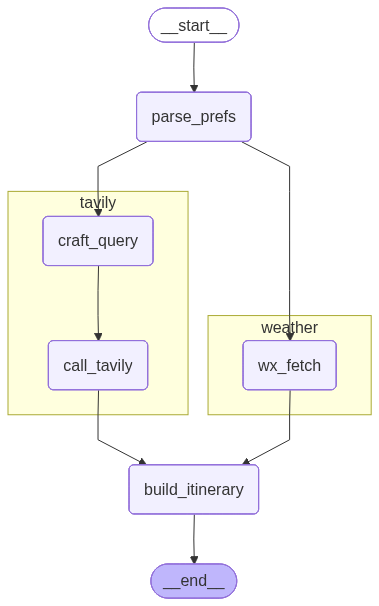

In [22]:
class ItinerarySchema(BaseModel):
    itinerary: str = Field(..., description="A formatted, day-by-day NYC itinerary")

llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_struct = llm.with_structured_output(ItinerarySchema)


def _trim(s: str, n: int = 2000) -> str:
    s = (s or "").strip()
    return s if len(s) <= n else s[:n] + " ..."


def build_itinerary_llm(state: NYCState):

    prompt_txt = str(state.get("prompt", "")).strip()
    weather_txt = _trim(str(state.get("weather_summary", "")))
    web_txt = _trim(str(state.get("web_summary", "")))
    prefs_txt = json.dumps(state.get("prefs", {}), ensure_ascii=False)
    days_val = state.get("days", 2)

    messages = [
        {
            "role": "system",
            "content": (
                "You are a helpful NYC trip planner. Using the user's prompt, weather info, "
                "web context, preferences, and number of days, produce a formatted, day-by-day itinerary. "
                "Cluster sights to minimize transit and suggest food near subway stops. "
                "Include one practical tip at the end of each day. "
                "Return ONLY a JSON object matching the provided schema."
            ),
        },
        {
            "role": "user",
            "content": (
                f"Prompt: {prompt_txt}\n\n"
                f"Weather:\n{weather_txt}\n\n"
                f"Web Summary:\n{web_txt}\n\n"
                f"Preferences: {prefs_txt}\n"
                f"Days: {days_val}"
            ),
        },
    ]

    result = llm_struct.invoke(messages)

    if hasattr(result, "model_dump"):
        data = result.model_dump()
    elif hasattr(result, "dict"):
        data = result.dict()
    else:
        data = result

    raw = data.get("itinerary", "")
    itinerary = str(raw).strip() if raw is not None else ""
    if not itinerary or itinerary in {"Ellipsis", "..."}:
        itinerary = "No itinerary generated. (The model returned an empty/invalid value.)"

    return {
        "itinerary": itinerary,
        "notes": [f"itinerary:days={days_val},prefs={prefs_txt}"],
    }

g = StateGraph(state_schema=NYCState)
g.add_node("parse_prefs", parse_prefs_llm)
g.add_node("weather", weather_graph)      
g.add_node("tavily", tavily_graph)        
g.add_node("build_itinerary", build_itinerary_llm)

g.add_edge(START, "parse_prefs")
g.add_edge("parse_prefs", "weather")
g.add_edge("parse_prefs", "tavily")
g.add_edge("weather", "build_itinerary")
g.add_edge("tavily", "build_itinerary")
g.add_edge("build_itinerary", END)

nyc_graph = g.compile()
display(Image(nyc_graph.get_graph(xray=1).draw_mermaid_png()))


This runs the **entire NYC planner** with a real user prompt.

- `init_state` provides only the prompt; all other fields start empty.
- `nyc_graph.invoke(init_state)` triggers:
  1. LLM prefs parsing  
  2. Live weather fetch  
  3. Live Tavily search  
  4. LLM itinerary generation  

- Printing `out["itinerary"]` shows the final trip plan.  
- Printing `out["notes"]` shows the breadcrumbs produced along the way.


In [23]:
init_state = {
    "prompt": "We’re two adults for 3 days. Love museums and great food. Prefer walkable routes.",
    "prefs": {},            
    "days": 0,              
    "weather_summary": "",  
    "query": "",            
    "web_summary": "",      
    "itinerary": "",
    "notes": []
}

out = nyc_graph.invoke(init_state)
print(out["itinerary"])
print(out["notes"])


### Day 1: Exploring Midtown and Museum Mile

**Morning:**
- **Breakfast at Chelsea Market** (75 9th Ave): Start your day with a coffee and pastry at this vibrant market hall. Explore the gourmet food shops and boutiques.
- **Travel to Museum Mile**: Take the subway from 14th St (A, C, E lines) to 86th St (4, 5, 6 lines).

**Midday:**
- **The Frick Collection**: Visit this beautiful museum just outside Central Park. Enjoy the selection of paintings and sculptures.
- **Lunch at The Modern**: Located near the Museum of Modern Art, this restaurant offers a refined dining experience.

**Afternoon:**
- **Solomon R. Guggenheim Museum**: Explore the iconic architecture and impressive art collection.

**Evening:**
- **Dinner at Dos Caminos** (1567 Broadway & 47th St): Enjoy a Mexican meal in Times Square.

**Practical Tip:** Dress warmly and in layers, as temperatures are low and it may feel colder with the wind chill.

---

### Day 2: Downtown and Cultural Highlights

**Morning:**
- **Breakfa

In [24]:
print(out["itinerary"])

### Day 1: Exploring Midtown and Museum Mile

**Morning:**
- **Breakfast at Chelsea Market** (75 9th Ave): Start your day with a coffee and pastry at this vibrant market hall. Explore the gourmet food shops and boutiques.
- **Travel to Museum Mile**: Take the subway from 14th St (A, C, E lines) to 86th St (4, 5, 6 lines).

**Midday:**
- **The Frick Collection**: Visit this beautiful museum just outside Central Park. Enjoy the selection of paintings and sculptures.
- **Lunch at The Modern**: Located near the Museum of Modern Art, this restaurant offers a refined dining experience.

**Afternoon:**
- **Solomon R. Guggenheim Museum**: Explore the iconic architecture and impressive art collection.

**Evening:**
- **Dinner at Dos Caminos** (1567 Broadway & 47th St): Enjoy a Mexican meal in Times Square.

**Practical Tip:** Dress warmly and in layers, as temperatures are low and it may feel colder with the wind chill.

---

### Day 2: Downtown and Cultural Highlights

**Morning:**
- **Breakfa

In [25]:
print(out["notes"])

['prefs:{"museums": false, "food": false, "indoor_bias": false, "walkable": false, "subway_nearby": true}', 'days:2', 'prefs:{"museums": false, "food": false, "indoor_bias": false, "walkable": false, "subway_nearby": true}', 'days:2', 'tavily_query:', 'tavily:live:5 results', 'prefs:{"museums": false, "food": false, "indoor_bias": false, "walkable": false, "subway_nearby": true}', 'days:2', 'weather:live_openweather:2d', 'itinerary:days=2,prefs={"museums": false, "food": false, "indoor_bias": false, "walkable": false, "subway_nearby": true}']


In [26]:
from IPython.display import HTML
import html
it = html.escape(out["itinerary"])
HTML(f'<div style="max-height:500px; overflow:auto; white-space:pre-wrap">{it}</div>')
